# Create handwritten digits with GANs 


The [GAN or Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) are one of the latest advances in Deep Learning, the principle is quite simple. Instead of having one model that will generate images, we're going to have two models: 

* **A generator** : The first one is going to try to create images from the image dataset we give it. 
* **A discriminator**: Another model will try to distinguish the images created by the generator from the real images.

Everything is then a battle between the generator which will try to create images so perfect that the discriminator can no longer distinguish _true_ images from _generated_ images.

Let's try to implement this on MNIST: 

![](https://tensorflow.org/images/gan/dcgan.gif)

* Import next librairies: 
  * time
  * tensorflow
  * matplotlib.pyplot
  * numpy
  * display from IPython

In [1]:
import time
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from IPython import display

* We need to download the MNIST dataset. You can do this via [`tf.keras.datasets.mnist`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

In [10]:
(X_train, y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data()

* We're gonna have to go through a data pre-processing phase. 
  * Start by reshaping your training images to look like this: (sample, height, width, channels = 1). 
  * Convert these images to `float32`.
  * Normalize your images so that each pixel is within the $\begin{bmatrix}
-1,1
\end{bmatrix}$ range. You can simply subtract each pixel by 127.5 ($\frac{255}{2}$) and then divide by 127.5 ($\frac{255}{2}$).

In [11]:
sample, height, width = X_train.shape
X_train = (X_train.reshape(sample, height, width, 1).astype("float32") - 127.5) / 127.5

* View an image in your dataset via matplotlib 

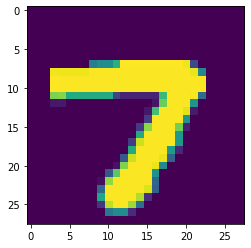

In [14]:
plt.imshow(X_train[np.random.randint(len(X_train))].squeeze())

* Create a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) with your training images. And apply the last preprocessing steps:
  * Shuffle with a `buffer_size` of 6000
  * Create 256 images batchs 

In [18]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(sample).batch(256)

* We will now create our _generator_. This model will take as input completely random pixels that we will call _noise_. The input will go through a series of layers [_Conv2DTranspose_](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Conv2DTranspose) which will produce an image from this random seed. This _Conv2DTranspose_ works the opposite of a convolution, which we call a _deconvolution_. So create a model with the following structure : 

    * Dense(7\*7\*256, use_bias=False, input_shape=(100,))
    * BatchNormalization()
    * LeakyReLU()

    * Reshape((7, 7, 256))

    * Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)
    * BatchNormalization()
    * LeakyReLU()

    * Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)
    * BatchNormalization()
    * LeakyReLU()

    * Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')

NB: The activation function [LeakyRelu()](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LeakyReLU) which is adapted for this kind of problem. LeakyRelu, unlike Relu, does not set the neuron to 0 if it is not active but leaves a gradient.

$f(x) = \alpha \times x$ for $x < 0$.

$f(x) = x$ for $x >= 0$

In [47]:
# Create a model
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Reshape((7, 7, 256)),
    tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
])

* Test your model by creating a completely random image. To do this: 
  * Create a random pixel tensor with a shape of (1, 100) ---> Try looking at [`tf.random.normal`](https://www.tensorflow.org/api_docs/python/tf/random/normal)
  * Apply your pattern to this random tensor 
  * View with plt

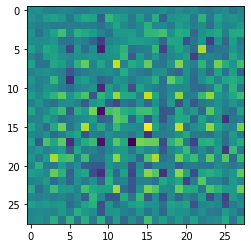

In [29]:
plt.imshow(generator(tf.random.normal((1, 100))).numpy().squeeze())
plt.show()

In [24]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

* Now let's create our _discriminator_. This template will be a simple binary CNN that will try to predict whether the image is a fake or a real one. You can take the following structure: 

  * Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1])
  * LeakyReLU()
  * Dropout(0.3)
  
  * Conv2D(128, (5, 5), strides=(2, 2), padding='same')
  * LeakyReLU()
  * Dropout(0.3)
  
  * Flatten()
  * Dense(1)

In [48]:
# Create a model
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
])

* Test your model on a random image. This will not give us accurate predictions, the goal is to verify that your model works. 

In [32]:
discriminator(generator(tf.random.normal((1, 100))))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00257534]], dtype=float32)>

* We will now define two cost functions: `discriminator_loss` and `generator_loss`.
  * **discriminator_loss**: should define how well our discriminator distinguishes false from real images 
  * **generator_loss**: should define at which our generator _deceives_ our discriminator.
  
  Create a `cross_entropy` variable that will store the function `tf.keras.losses.BinaryCrossentropy(from_logits=True)`

In [49]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy

* Set your `discriminator_loss`. This function will take a sum of two `losses`:
  * `real_loss`: which equals the crossentropy between y_true_real & y_pred.
  * `fake_loss`: which will be equal to the crossentropy between y_true_fake & y_pred
  
  `y_true_real` being the values that the model should have found on real images: This is actually simple like a matrix of 1
  
  `y_true_fake` being the values that should have been found by the dummy image model: This simply looks like a matrix of 0

In [54]:
def discriminator_loss(real_loss, fake_loss):
    return cross_entropy(tf.ones_like(real_loss), real_loss) + cross_entropy(tf.zeros_like(fake_loss), fake_loss)

* Now define `generator_loss` which should define how well our model manages to fool our `discriminator`. In other words, if our `discriminator` classify a fake image as a true image it should lower the `generator_loss`. 

So we just need to calculate the cross entropy between dummy images classified as real images and the predictions of our `discriminator` on dummy images. 

In [35]:
def generator_loss(fake_loss):
    return cross_entropy(tf.ones_like(fake_loss), fake_loss)

* Now let's define two optimizers for our two cost functions. Create two Adam optimizers with a learning rate of `1e-4` each. 

In [36]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

* We'll be able to create our training loop! Let's start by defining a few variables first: 
  * `EPOCHS = 50` ---> We will define 50 epochs for our loop. 
  * `noise_dim = 100` ---> The dimension of our random tensor 
  * `num_examples_to_generate = 16` ---> We will create 16 random images 
  * `seed = tf.random.normal([num_examples_to_generate, noise_dim])` ---> Our random images 

In [42]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

* We will now define a `train_step` function that will define how a step in the model training will occur. To do this, you will need to implement the following things:
  * Initialize a `noise` variable which will be equal to a random tensor wiith a shape (`batch_size`, `noise_dim`)
  * Start recording gradients in a block: `with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape`: 
    NB: Indeed, we will follow the gradients of the two cost functions `gen_loss` and `disc_loss`. Once this is done, you will have to inside the :
    * Apply your `generator` on your `noise` variable.
    * Apply your `discriminator` on your batch of real images and on your generated images 
    * Calculate the `gen_loss` of your `generator` on your fake image
    * Calculate the `disc_loss` of your `discriminator` between your real and generated images
  * Once you've coded your block, you'll have to apply your gradients to `gen_loss` & `disc_loss` 
    * You can do this via `gen_tape.gradient(loss, weights)` & `disc_tape.gradient(loss, weights)`. Feel free to look at this documentation to help you: [`GradientTape`](https://www.tensorflow.org/tutorials/eager/automatic_differentiation) & [`trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables)
  * Finally, apply your gradients using the optimizers you defined above. Feel free to use this documentation [`apply_gradients`](https://www.tensorflow.org/api_docs/python/tf/train/Optimizer#apply_gradients)

In [56]:
def train_step(batch):
    noise = tf.random.normal((len(batch), noise_dim))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        real_output = discriminator(batch, training=True)
        fake_output = discriminator(generator(noise, training=True), training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                    discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                                discriminator.trainable_variables))
    return gen_loss, disc_loss

* Before applying our training function, we will have to create a last function that will allow us to generate and save an image. This will allow us to look at the head of a batch of images and see how our model trains. Apply the following code to be able to watch and save an image:

```
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions [i, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
 ```

In [57]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

* Let's go! Let's start our training. For this, you'll need:

  * Create a first loop that iterates through the number of epochs you've defined.
  * You can use `time.time()` to record the time each iteration takes.
  * Inside this loop create a new loop that will iterate on each of the batches of your `train_set`.
    * Inside this last loop, apply your `train_step` function on your batch of images
    * Add a `display.clear_output(wait=True)` line to avoid having too many outputs in our console. 
    * Apply the function `generate_and_save_images` with your `generator`, the number of epochs + 1 and `test_input` as arguments.
  * Once you have completed your epoch loop, apply your `generate_and_save_images` function one last time to display your images created by your template. 

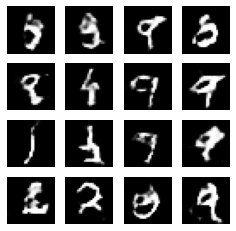

Epoch 33 took (33, 23.61261820793152) sec


KeyboardInterrupt: ignored

In [58]:
generator_losses = []
discriminator_losses = []

for epoch in range(EPOCHS):
    start = time.time()
    epoch_gen_loss_avg = tf.keras.metrics.Mean()
    epoch_dis_loss_avg = tf.keras.metrics.Mean()

    for batch, target in dataset:
        gen_loss, dis_loss = train_step(batch)
        epoch_gen_loss_avg(gen_loss)
        epoch_dis_loss_avg(dis_loss)
  
    generator_losses.append(gen_loss)
    discriminator_losses.append(dis_loss)

    # Clear the previous image and save the new one
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epoch + 1,
                           seed)

    print (f'Epoch {epoch + 1} took {epoch + 1, time.time() - start} sec')

# Generate the last image
display.clear_output(wait=True)
generate_and_save_images(generator,
                         EPOCHS,
                         seed)

Bravo! You managed to create images using a simple GAN principle. It's a great step forward in Deep Learning. You can try to apply it to other types of images now. 

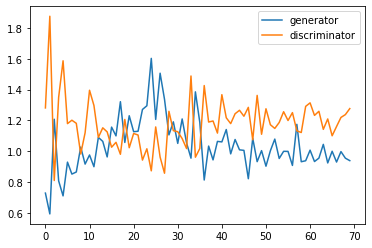

In [ ]:
plt.plot(generator_losses, label='generator')
plt.plot(discriminator_losses, label='discriminator')
plt.legend()
plt.show()